# Simplified detection of urban types

Example adapted from the [SDSC 2021 Workshop](https://github.com/martinfleis/sdsc21-workshop) led by Martin Fleischmann. You can see the recording of the workshop on [YouTube](https://www.youtube.com/watch?v=itUX56Ks1UE).

This example illustrates the potential of morphometrics captured by `momepy` in capturing the structure of cities. We will pick a town, fetch its data from the OpenStreetMap, and analyse it to detect individual types of urban structure within it.

This method is only illustrative and is based on the more extensive one published by Fleischmann et al. (2021) available from [https://github.com/martinfleis/numerical-taxonomy-paper](https://github.com/martinfleis/numerical-taxonomy-paper).

> Fleischmann M, Feliciotti A, Romice O and Porta S (2021) Methodological Foundation of a Numerical Taxonomy of Urban Form. Environment and Planning B: Urban Analytics and City Science, doi: 10.1177/23998083211059835

It depends on the following packages:

```
- momepy
- osmnx
- clustergram
- bokeh
- scikit-learn
- geopy
- ipywidgets
```


In [54]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas
import bokeh

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Znojmo, Czechia'
local_crs = 5514

We can interactively explore the place we just selected.

In [3]:
geopandas.tools.geocode(place).explore()

## Input data

We can use ``OSMnx`` to quickly download data from OpenStreetMap. If you intend to download larger areas, we recommend using ``pyrosm`` instead.

### Buildings

In [4]:
buildings = osmnx.geometries.geometries_from_place(place, tags={'building':True})
buildings.head()

/tmp/ipykernel_4350/1465348557.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = osmnx.geometries.geometries_from_place(place, tags={'building':True})


power                   geometry amenity brand  \
element_type osmid                                                       
node         3372076291   NaN  POINT (16.05376 48.84683)     NaN   NaN   
             3372076393   NaN  POINT (16.05581 48.84158)     NaN   NaN   
             3372076394   NaN  POINT (16.05867 48.83522)     NaN   NaN   
             3372076428   NaN  POINT (16.03949 48.85599)     NaN   NaN   
             3372076429   NaN  POINT (16.04133 48.85501)     NaN   NaN   

                        brand:wikidata brand:wikipedia check_date  \
element_type osmid                                                  
node         3372076291            NaN             NaN        NaN   
             3372076393            NaN             NaN        NaN   
             3372076394            NaN             NaN        NaN   
             3372076428            NaN             NaN        NaN   
             3372076429            NaN             NaN        NaN   

                                   name operator operator:wikidata  ...  \
element_type osmid                                                  ...   
node         3372076291    7/I/10/A-120      NaN               NaN  ...   
             3372076393  7/I/11/A-140 Z      NaN               NaN  ...   
             3372076394    7/I/12/A-220      NaN               NaN  ...   
             3372076428         7/I/8/E      NaN               NaN  ...   
             3372076429         7/I/9/E      NaN               NaN  ...   

                        fuel:octane_95 voltage source_1 pillbox name:signed  \
element_type osmid                                                            
node         3372076291            NaN     NaN      NaN     NaN         NaN   
             3372076393            NaN     NaN      NaN     NaN         NaN   
             3372076394            NaN     NaN      NaN     NaN         NaN   
             3372076428            NaN     NaN      NaN     NaN         NaN   
             3372076429            NaN     NaN      NaN     NaN         NaN   

                         ref monitoring:water_level ways type emergency  
element_type osmid                                                       
node         3372076291  NaN                    NaN  NaN  NaN       NaN  
             3372076393  NaN                    NaN  NaN  NaN       NaN  
             3372076394  NaN                    NaN  NaN  NaN       NaN  
             3372076428  NaN                    NaN  NaN  NaN       NaN  
             3372076429  NaN                    NaN  NaN  NaN       NaN  

[5 rows x 113 columns]

The OSM input may need a bit of cleaning to ensure only proper polygons are kept.

In [5]:
buildings.geom_type.value_counts()

Polygon    12205
Point          8
Name: count, dtype: int64

In [6]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [7]:
buildings.geom_type.value_counts()

Polygon    12205
Name: count, dtype: int64

And we should re-project the data from WGS84 to the local projection in meters (momepy default values assume meters not feet or degrees). We will also drop unnecessary columns.

In [8]:
buildings = buildings[["geometry"]].to_crs(local_crs)

Finally, we can assign unique ID to each row.

In [9]:
buildings["uID"] = range(len(buildings))
buildings.head()

,geometry,uID
0,"POLYGON ((-643743.474 -1193358.749, -643743.30...",0
1,"POLYGON ((-643751.446 -1193530.633, -643749.37...",1
2,"POLYGON ((-643281.601 -1193130.831, -643283.76...",2
3,"POLYGON ((-643381.904 -1193174.697, -643388.48...",3
4,"POLYGON ((-643370.450 -1193130.215, -643398.26...",4


### Streets

Similar operations are done with streets.

In [10]:
osm_graph = osmnx.graph_from_place(place, network_type='drive')
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [11]:
streets.head()

osmid  ref        name      highway  oneway  \
u         v          key                                                   
74103628  639231391  0    33733060  361  Přímětická    secondary   False   
          3775990798 0    33733060  361  Přímětická    secondary   False   
639231391 74103628   0    33733060  361  Přímětická    secondary   False   
          74142638   0    33733060  361  Přímětická    secondary   False   
          639231314  0    50313241  NaN  Mičurinova  residential    True   

                         reversed   length  \
u         v          key                     
74103628  639231391  0      False   24.574   
          3775990798 0       True   60.354   
639231391 74103628   0       True   24.574   
          74142638   0      False   54.260   
          639231314  0      False  101.376   

                                                                   geometry  \
u         v          key                                                      
74103628  639231391  0    LINESTRING (-643239.057 -1192850.232, -643229....   
          3775990798 0    LINESTRING (-643239.057 -1192850.232, -643241....   
639231391 74103628   0    LINESTRING (-643229.639 -1192872.949, -643239....   
          74142638   0    LINESTRING (-643229.639 -1192872.949, -643219....   
          639231314  0    LINESTRING (-643229.639 -1192872.949, -643233....   

                         maxspeed lanes bridge junction width tunnel access  
u         v          key                                                     
74103628  639231391  0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
          3775990798 0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
639231391 74103628   0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
          74142638   0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
          639231314  0        NaN   NaN    NaN      NaN   NaN    NaN    NaN

We can also do some preprocessing using momepy to ensure we have proper network topology.

In [12]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

/home/conda/global/3b39f5ba4c243d8e72bd1fb8fc9d66b12ee0df9b6209421efb783fde15272f07-20230707-231950-859704-37-answering-geospatial-questions/lib/python3.10/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as S-JTSK / Krovak East North (the single non-null crs provided).
  warnings.warn(


In [13]:
streets.head()

,geometry,nID
0,"LINESTRING (-643239.057 -1192850.232, -643229....",0
1,"LINESTRING (-643239.057 -1192850.232, -643241....",1
2,"LINESTRING (-643229.639 -1192872.949, -643239....",2
3,"LINESTRING (-643229.639 -1192872.949, -643219....",3
4,"LINESTRING (-643229.639 -1192872.949, -643233....",4


## Generated data

### Tessellation

Given building footprints:

![blg](http://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_3_0.png)

We can generate a spatial unit using morphological tessellation:

![tess](http://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_14_0.png)

In [14]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/tmp/ipykernel_4350/1328706492.py:3: UserWarning: Tessellation does not fully match buildings. 22 element(s) collapsed during generation - unique_id: {3972, 11527, 11528, 8586, 3982, 11535, 4246, 10518, 4249, 9113, 4253, 4254, 4258, 4259, 11308, 4061, 4208, 10739, 10740, 9078, 4216, 4219}.
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/tmp/ipykernel_4350/1328706492.py:3: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. `unique_id` of affected elements: [4198, 3241, 11839, 3187, 11050].
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)


### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [15]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")
buildings.head()

,geometry,uID,index_right,nID
0,"POLYGON ((-643743.474 -1193358.749, -643743.30...",0,1044.0,1044.0
0,"POLYGON ((-643743.474 -1193358.749, -643743.30...",0,1045.0,1045.0
1,"POLYGON ((-643751.446 -1193530.633, -643749.37...",1,1459.0,1459.0
2,"POLYGON ((-643281.601 -1193130.831, -643283.76...",2,242.0,242.0
2,"POLYGON ((-643281.601 -1193130.831, -643283.76...",2,880.0,880.0


Clean duplicates and attach the network ID to the tessellation as well.

In [16]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters. For details see the User Guide and the API reference.

### Dimensions

In [17]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [18]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
buildings['elongation'] = momepy.Elongation(buildings).series
tessellation['convexity'] = momepy.Convexity(tessellation).series
streets["linearity"] = momepy.Linearity(streets).series

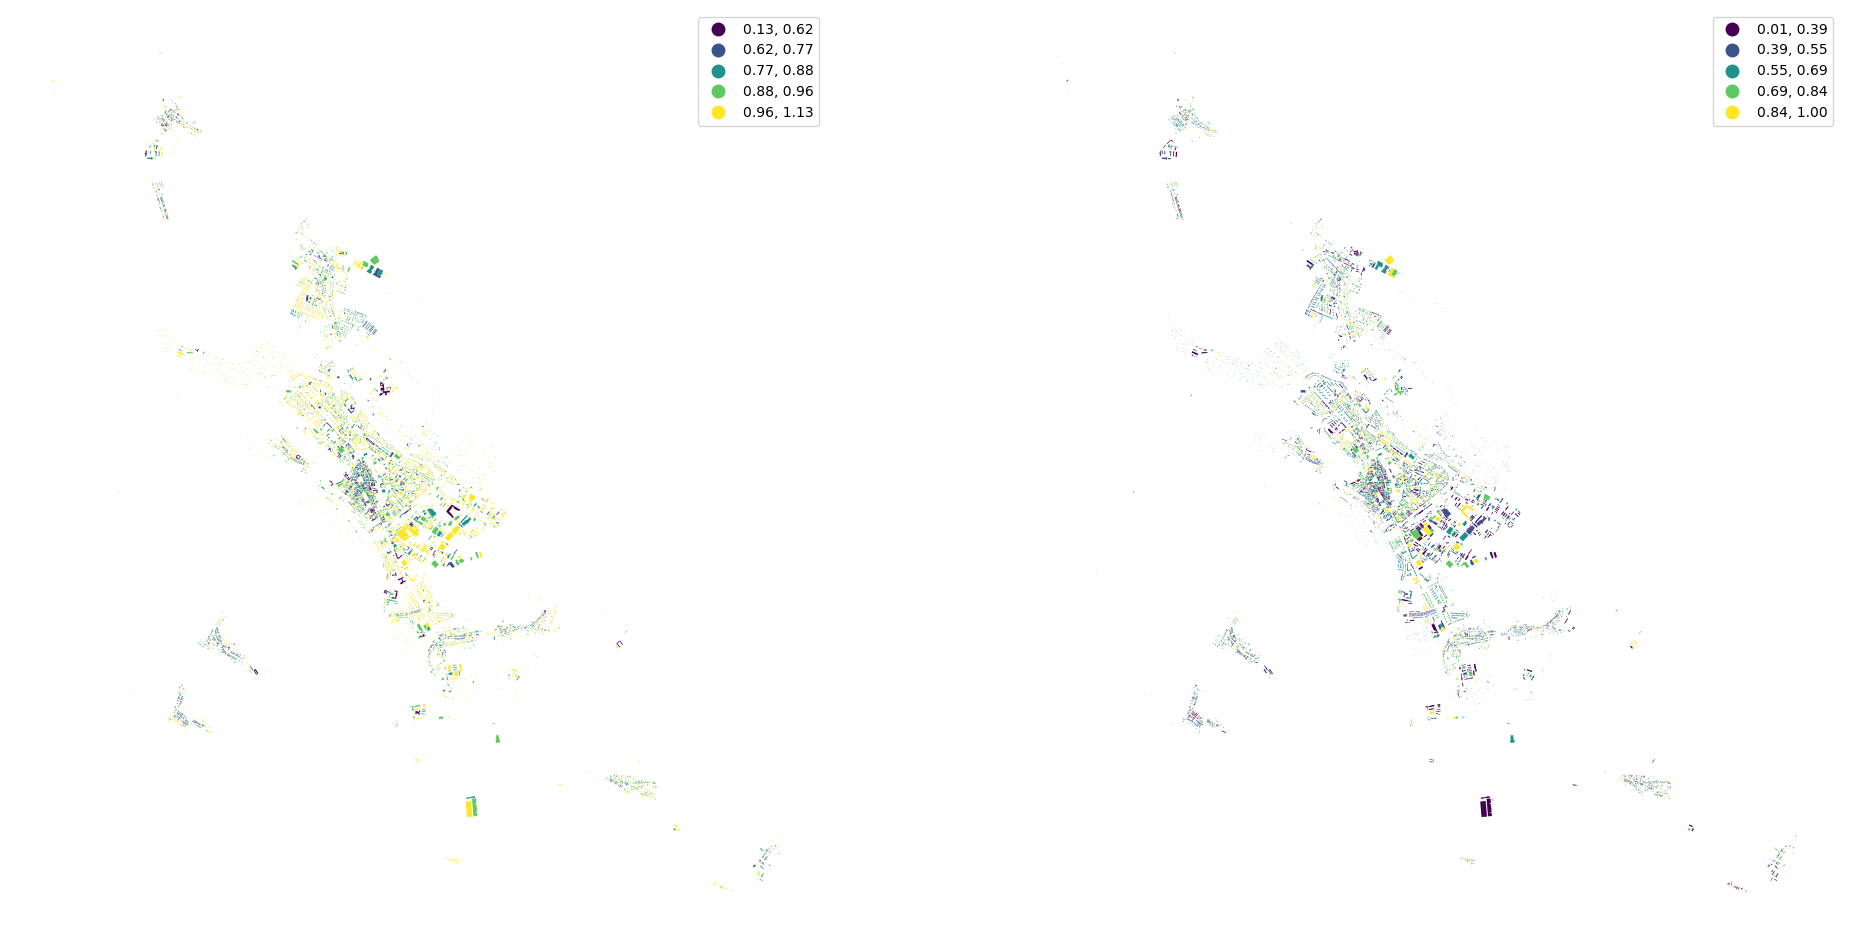

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

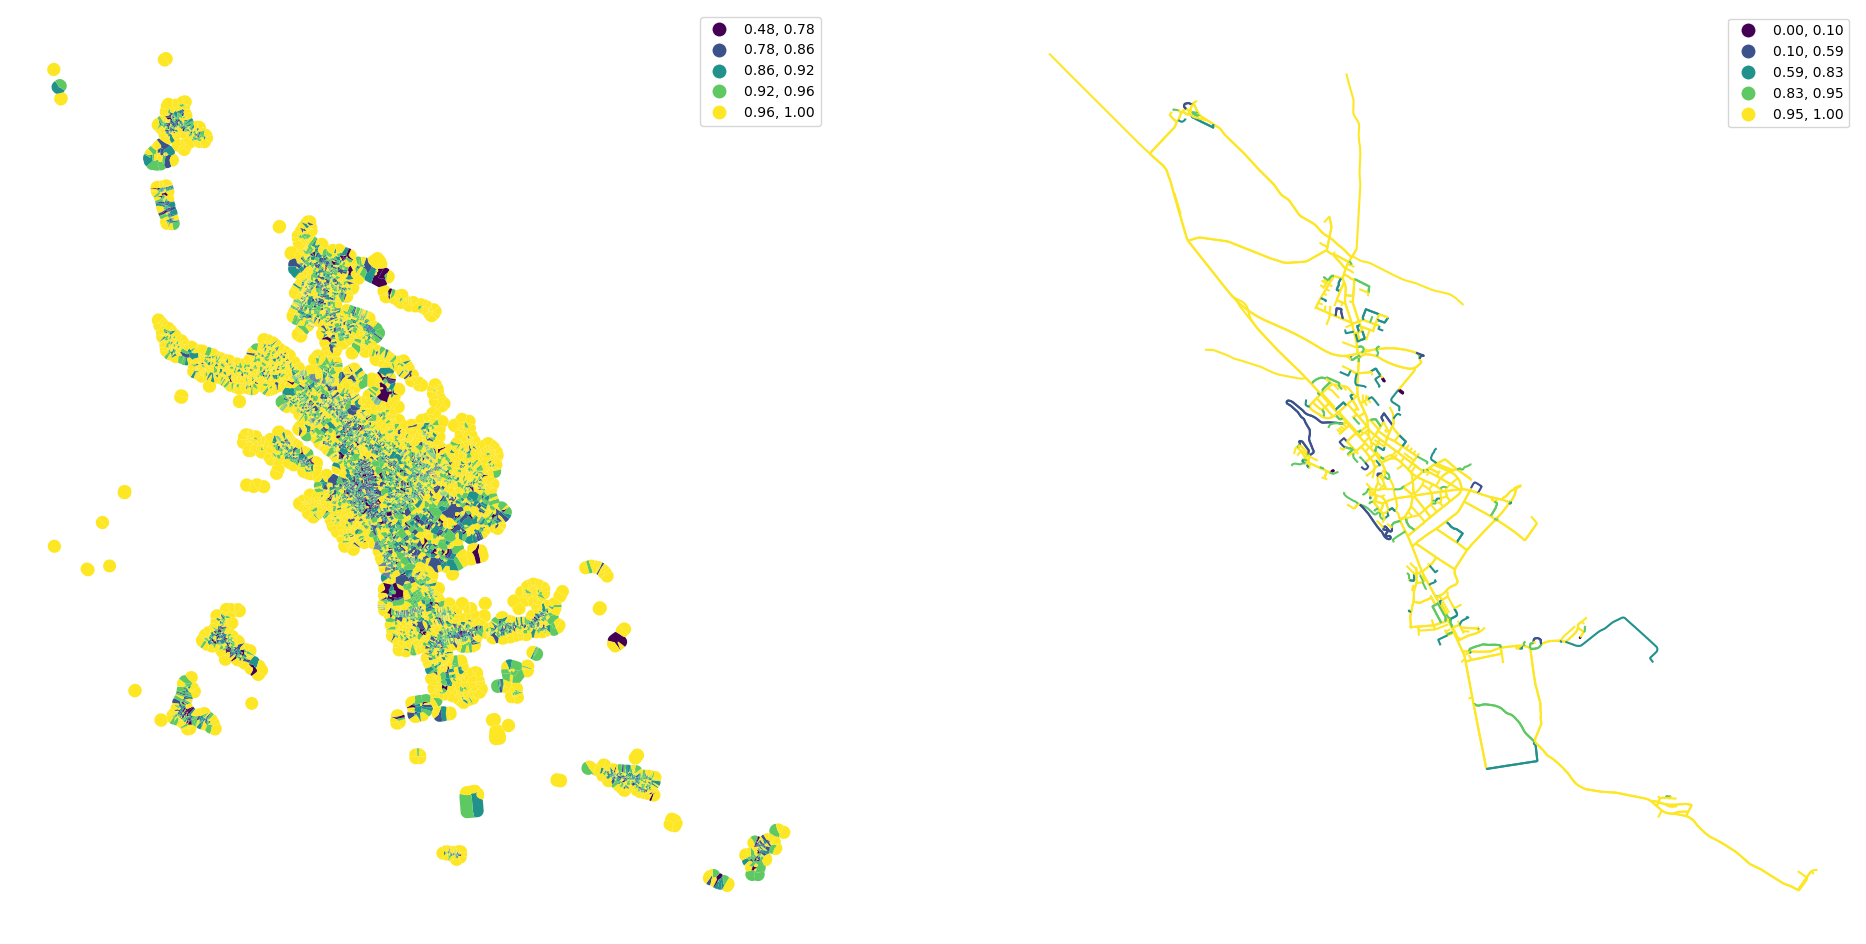

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Spatial distribution

/home/conda/global/3b39f5ba4c243d8e72bd1fb8fc9d66b12ee0df9b6209421efb783fde15272f07-20230707-231950-859704-37-answering-geospatial-questions/lib/python3.10/site-packages/momepy/distribution.py:135: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = gdf.sindex.query_bulk(gdf.geometry, predicate="intersects")


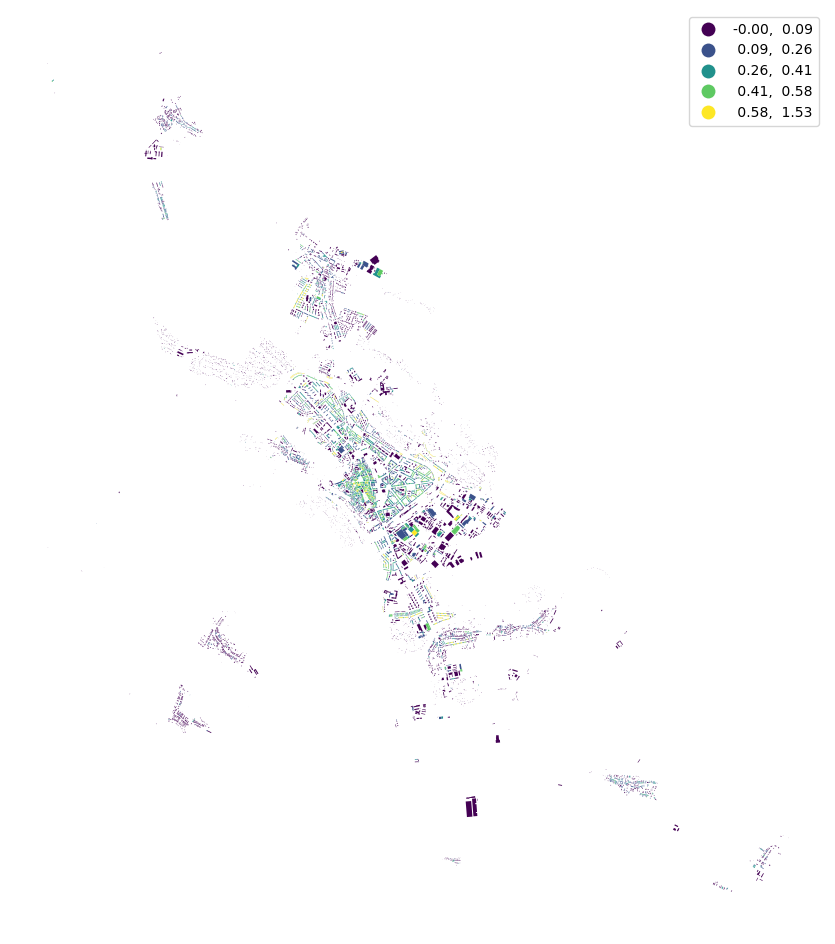

In [31]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

Generate spatial weights matrix using `libpysal`.

In [32]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [33]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

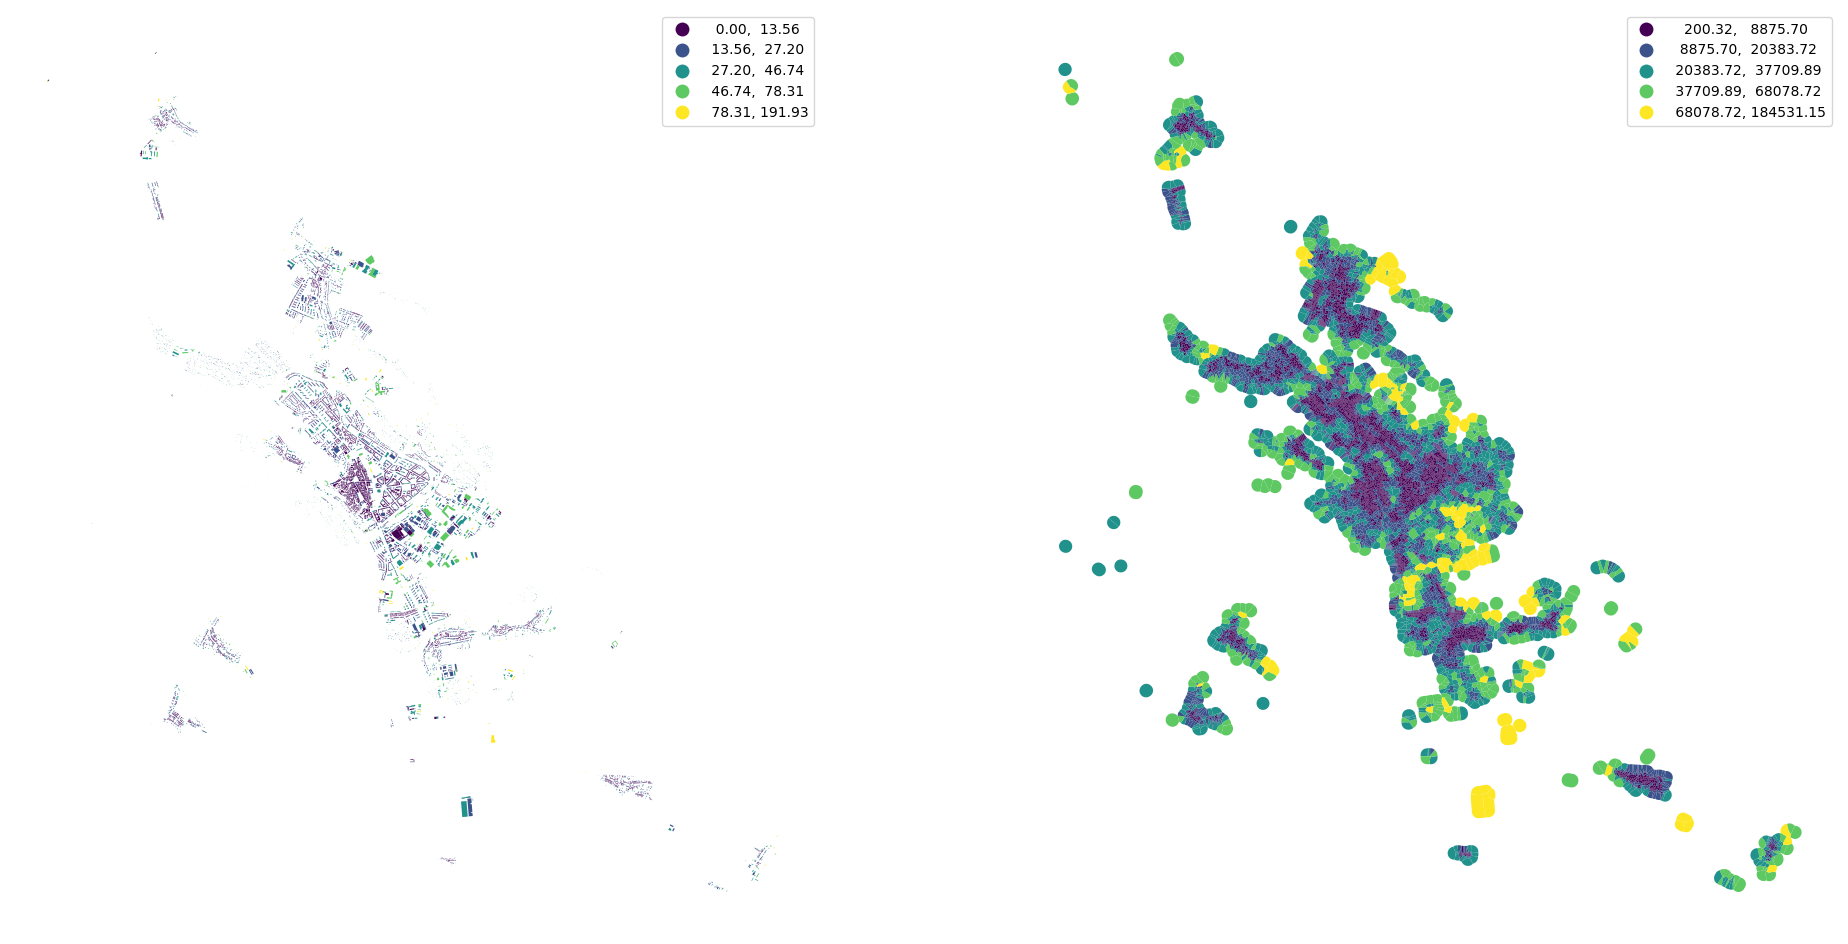

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [35]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/home/conda/global/3b39f5ba4c243d8e72bd1fb8fc9d66b12ee0df9b6209421efb783fde15272f07-20230707-231950-859704-37-answering-geospatial-questions/lib/python3.10/site-packages/mapclassify/classifiers.py:1775: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 0.
  warnings.warn(
/home/conda/global/3b39f5ba4c243d8e72bd1fb8fc9d66b12ee0df9b6209421efb783fde15272f07-20230707-231950-859704-37-answering-geospatial-questions/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/conda/global/3b39f5ba4c243d8e72bd1fb8fc9d66b12ee0df9b6209421efb783fde15272f07-20230707-231950-859704-37-answering-geospatial-questions/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

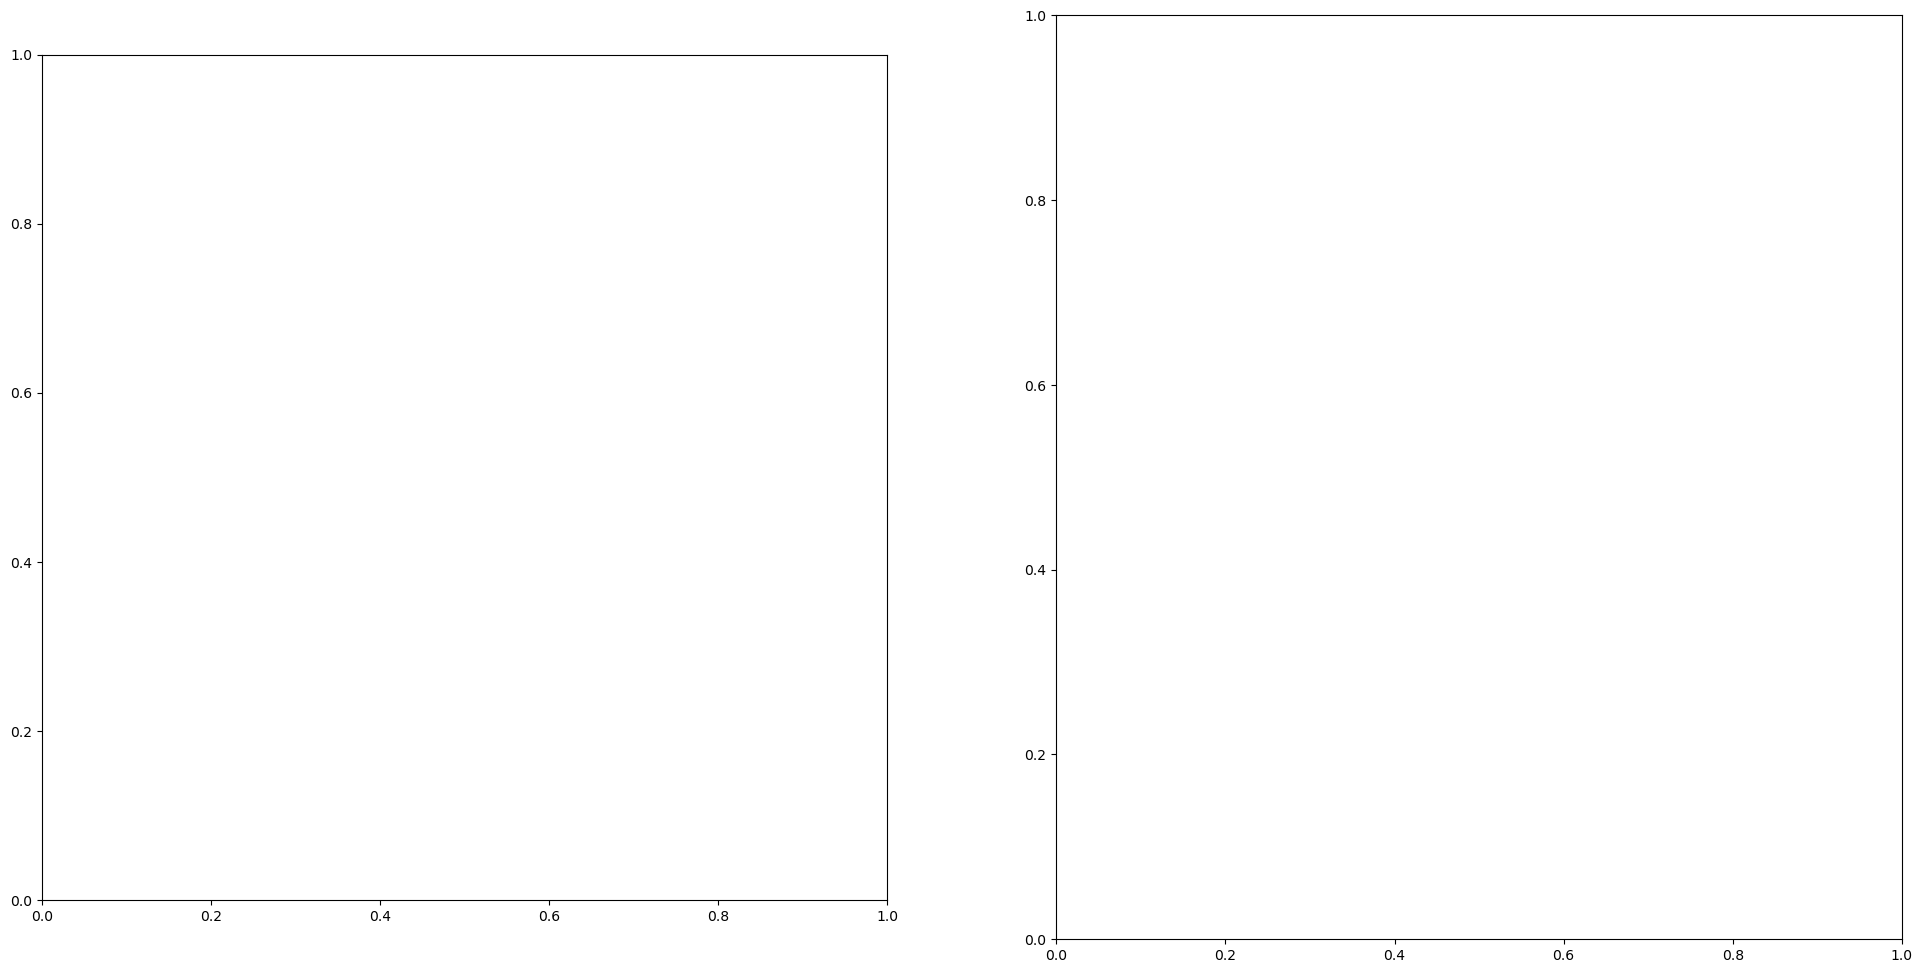

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [37]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

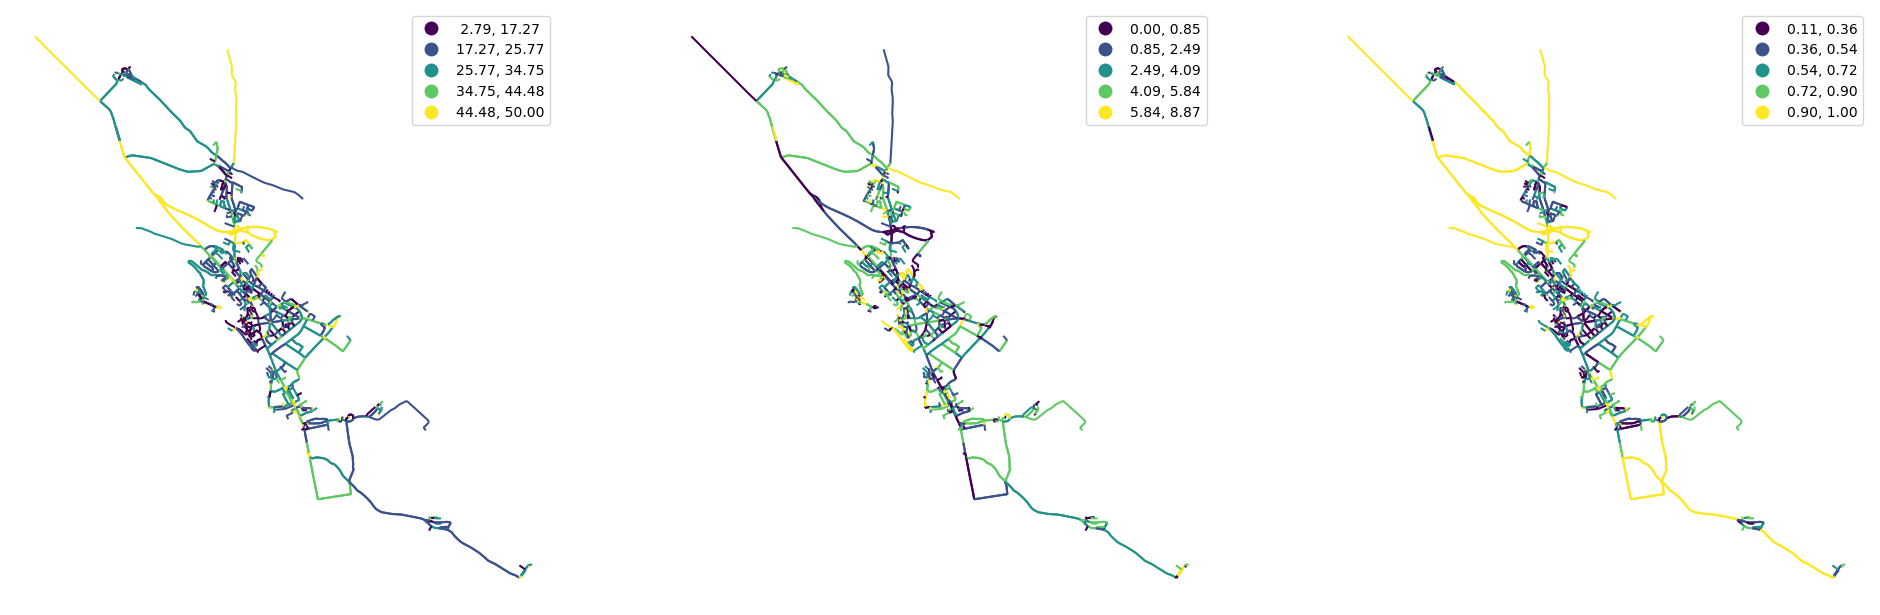

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

### Intensity

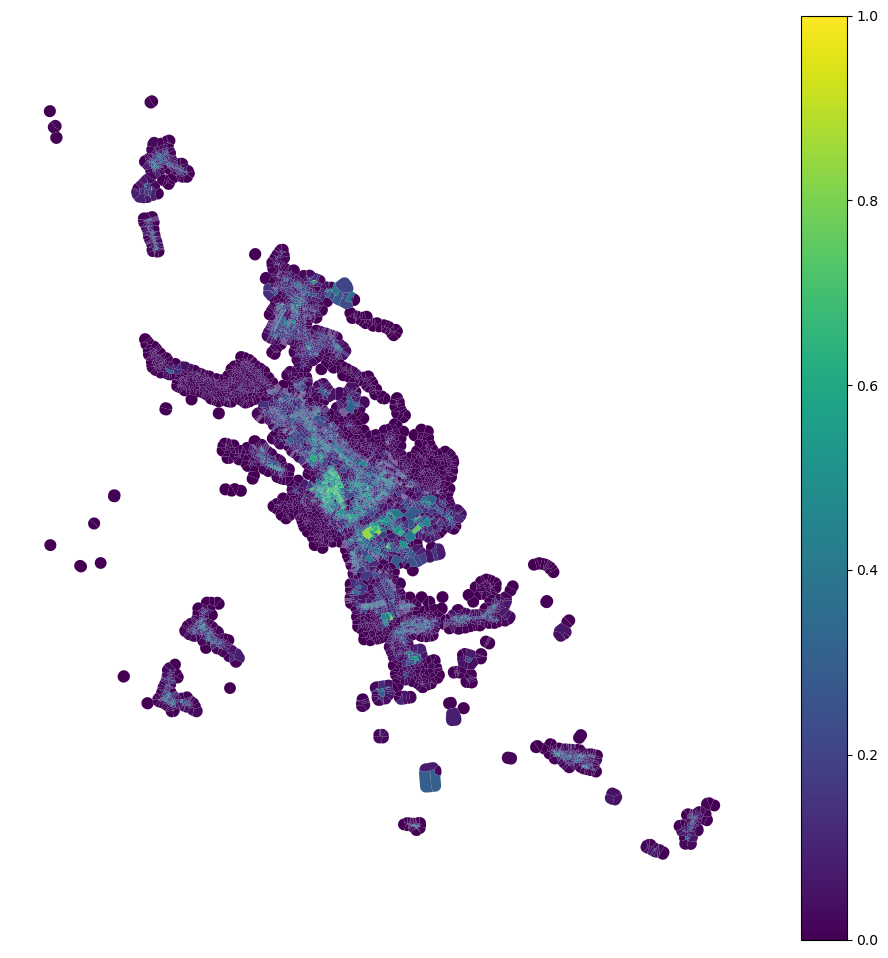

In [39]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()

### Connectivity

In [40]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, streets = momepy.nx_to_gdf(graph)

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/759 [00:00<?, ?it/s]

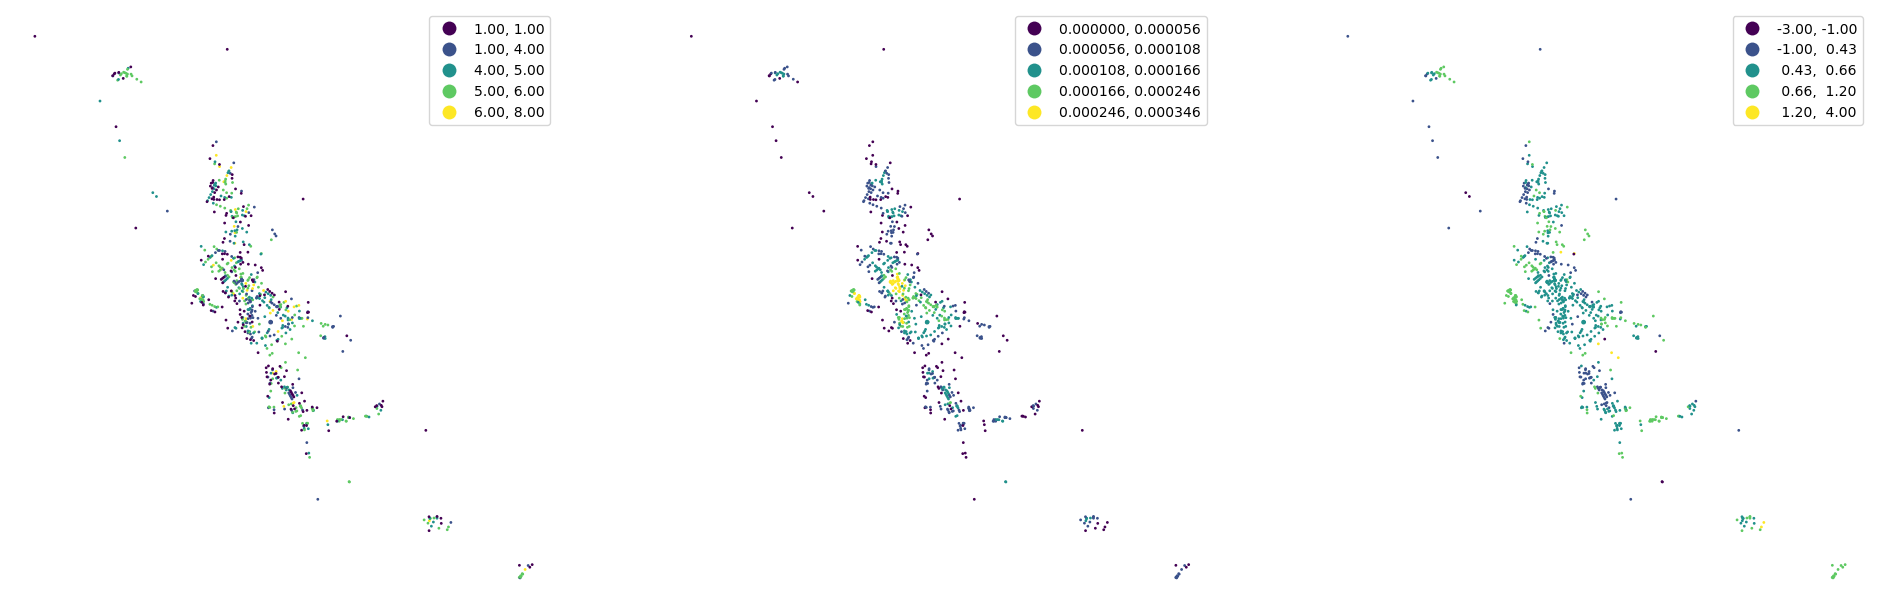

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [42]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

  0%|          | 0/12205 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [43]:
tessellation.head()

,uID,geometry,nID,area,convexity,neighbors,covered_area,car
0,5376,"POLYGON ((-637358.313 -1200006.277, -637357.92...",633.0,27736.670899,0.995293,0.003108,41793.250297,0.007476
1,5341,"POLYGON ((-636869.686 -1199824.120, -636870.16...",632.0,19855.193193,0.942935,0.005466,56679.209971,0.022276
2,10523,"POLYGON ((-637462.192 -1199942.387, -637450.89...",633.0,5980.537476,0.900015,0.006719,23484.755029,0.066270
3,5375,"POLYGON ((-636581.133 -1199460.422, -636578.85...",1609.0,18362.214060,0.988620,0.003802,42309.584227,0.005690
4,10529,"POLYGON ((-637599.665 -1199909.097, -637595.79...",633.0,6221.647571,0.829355,0.010157,43342.518117,0.049808


In [44]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [45]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'degree', 'closeness', 'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [46]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

In [47]:
percentiles_joined = pandas.concat(percentiles, axis=1)
percentiles_joined.head()

,area_x_25,area_x_50,area_x_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,openness_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
0,7151.505439,8460.534529,9102.552269,0.874500,0.888902,0.929755,0.006852,0.007068,0.007307,38509.340862,...,0.954774,6.0,6.0,6.0,0.000089,0.000089,0.000089,0.894737,0.894737,0.894737
1,2635.809199,3979.104339,7912.110750,0.906751,0.943435,0.980033,0.012226,0.021552,0.027465,34791.666675,...,1.000000,4.0,6.0,6.0,0.000096,0.000096,0.000098,0.809524,0.894737,1.000000
2,4869.281366,6119.443335,9102.552269,0.874500,0.947803,0.971754,0.007068,0.008105,0.009836,28474.090836,...,0.954774,6.0,6.0,6.0,0.000089,0.000089,0.000089,0.894737,0.894737,0.894737
3,774.500023,2527.511720,9756.635410,0.841715,0.946898,0.979633,0.012229,0.026525,0.032112,10886.683093,...,0.722222,1.0,4.0,7.0,0.000050,0.000065,0.000089,0.736842,0.809524,0.809524
4,5615.435874,6119.443335,8460.534529,0.888902,0.947803,0.971754,0.007598,0.008616,0.009836,27790.702394,...,0.954774,6.0,6.0,6.0,0.000089,0.000089,0.000089,0.894737,0.894737,0.894737


See the difference between original convexity and spatially lagged one.

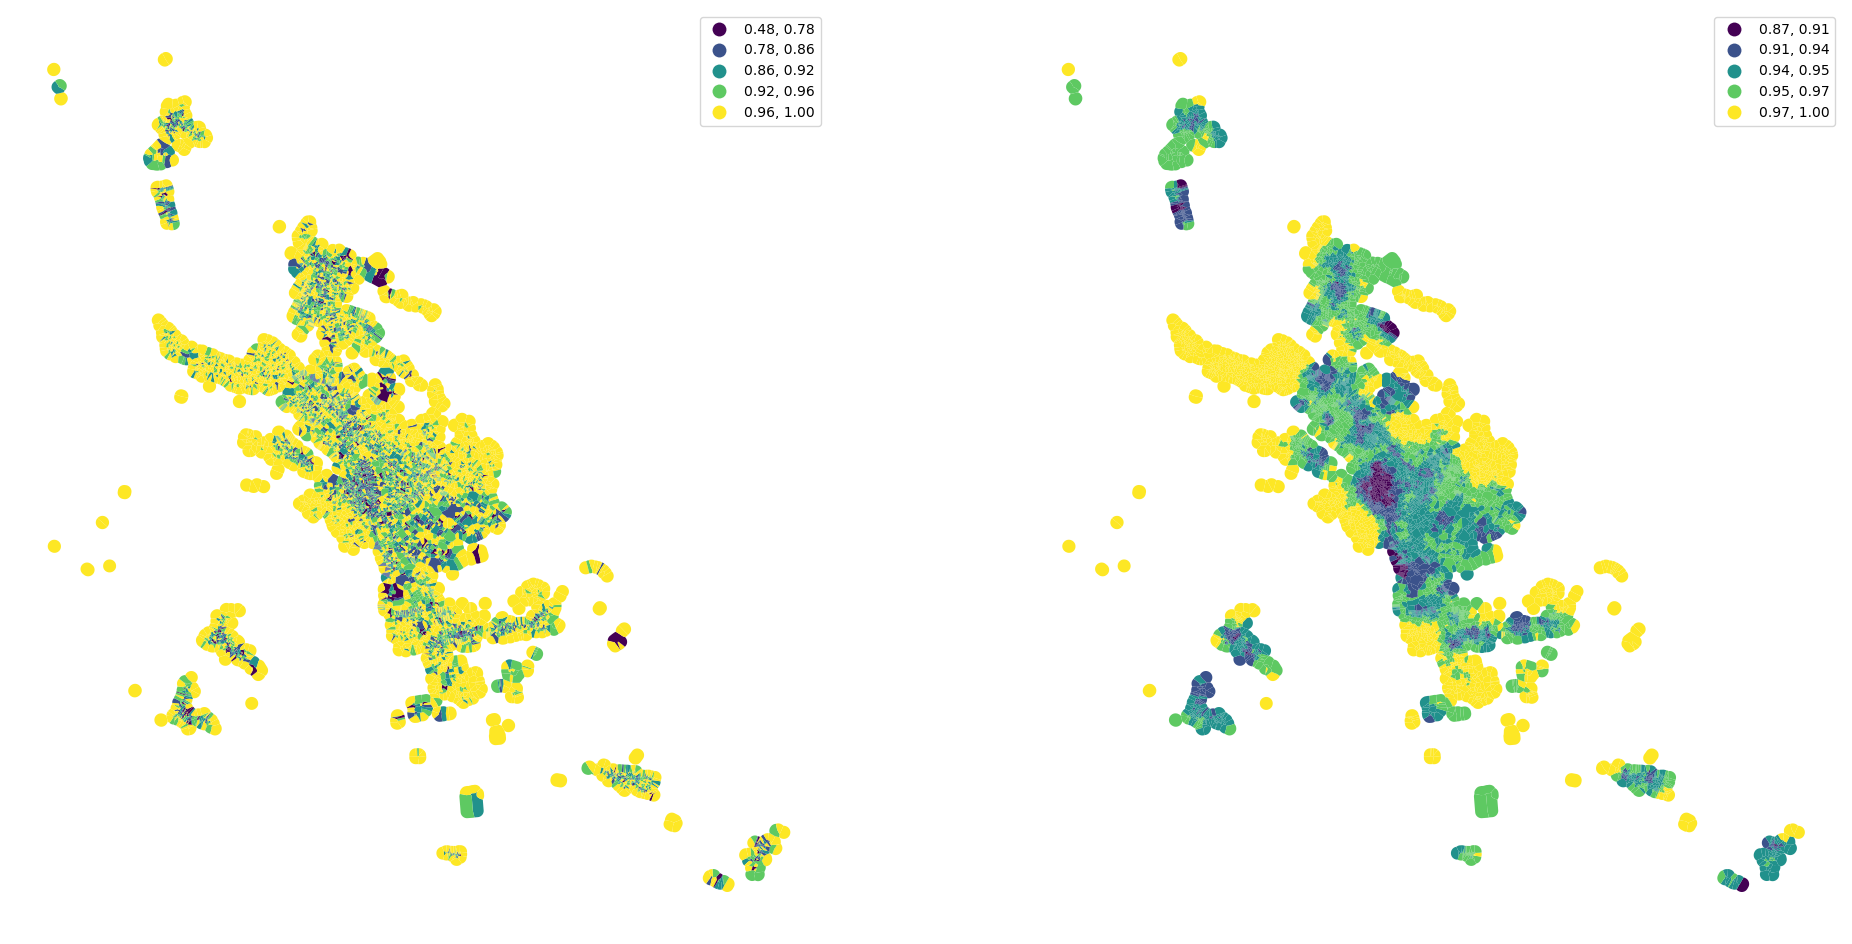

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Clustering

Now we can use obtained values within a cluster analysis that should detect types of urban structure.

Standardize values before clustering.

In [49]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()
standardized.head()

,area_x_25,area_x_50,area_x_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,openness_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
0,3.866221,3.527472,2.312120,-1.145789,-2.957061,-3.771826,-2.137911,-2.312076,-2.358039,4.242470,...,1.565010,1.163548,0.759543,0.402746,0.276884,0.020373,-0.198586,1.433410,1.190061,0.700183
1,1.180272,1.364124,1.909729,-0.175836,-0.341998,0.402189,-1.740949,-1.492048,-1.506023,3.739107,...,1.792533,0.116081,0.759543,0.402746,0.388939,0.122158,-0.069828,1.113355,1.190061,0.993389
2,2.508748,2.397343,2.312120,-1.145789,-0.132516,-0.285177,-2.121984,-2.253378,-2.251163,2.883724,...,1.565010,1.163548,0.759543,0.402746,0.276884,0.020373,-0.198586,1.433410,1.190061,0.700183
3,0.073160,0.663388,2.533212,-2.131836,-0.175907,0.368939,-1.740752,-1.210459,-1.309606,0.502436,...,0.395097,-1.455118,-0.365874,1.025526,-0.384724,-0.360898,-0.203664,0.840368,0.876476,0.462826
4,2.952563,2.397343,2.095107,-0.712639,-0.132516,-0.285177,-2.082816,-2.224445,-2.251163,2.791195,...,1.565010,1.163548,0.759543,0.402746,0.276884,0.020373,-0.198586,1.433410,1.190061,0.700183


### How many clusters?

To determine how many clusters we should aim for, we can use a little package called `clustergram`. See its [documentation](https://clustergram.readthedocs.io) for details.

In [50]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=42)
cgram.fit(standardized.fillna(0))

show(cgram.bokeh())

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.5454540252685547 seconds.
K=3 fitted in 0.9113335609436035 seconds.
K=4 fitted in 0.7389140129089355 seconds.
K=5 fitted in 0.9087567329406738 seconds.
K=6 fitted in 0.8306190967559814 seconds.
K=7 fitted in 1.3071582317352295 seconds.
K=8 fitted in 1.3433074951171875 seconds.
K=9 fitted in 1.5711538791656494 seconds.
K=10 fitted in 1.324784755706787 seconds.
K=11 fitted in 1.5763225555419922 seconds.


Clustegram gives us also the final labels. (Normally, you would run the final clustering on much larger number of initialisations.)

In [51]:
cgram.labels.head()

,1,2,3,4,5,6,7,8,9,10,11
0,0,1,2,2,1,2,1,6,3,6,9
1,0,1,2,2,1,2,1,6,3,6,9
2,0,1,2,2,1,2,1,6,3,6,9
3,0,1,0,3,4,0,4,0,4,0,8
4,0,1,2,2,1,2,1,6,3,6,9


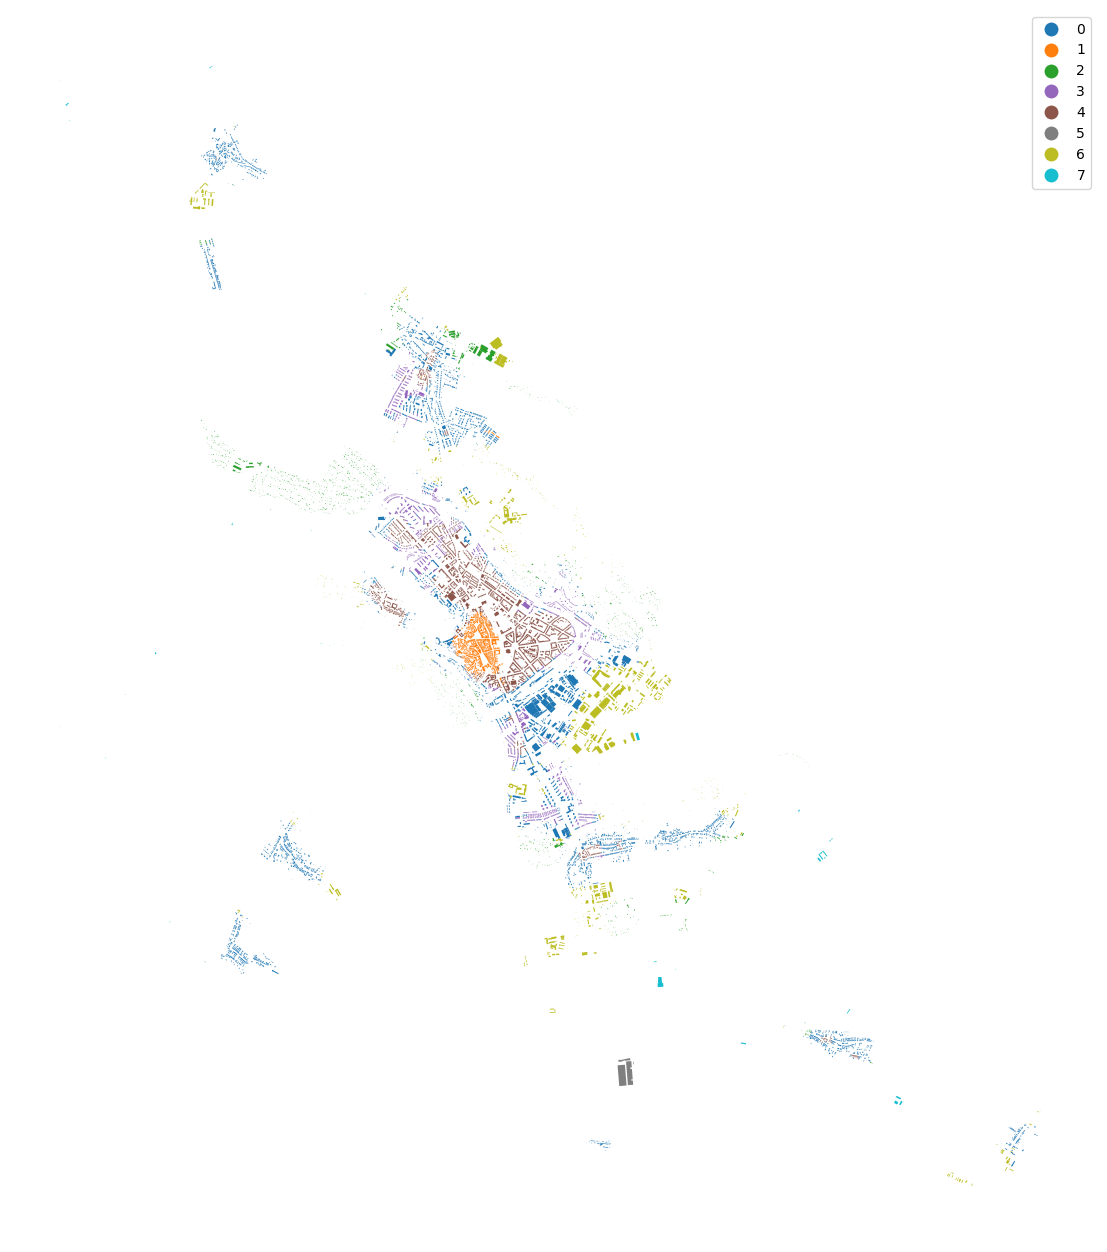

In [52]:
merged["cluster"] = cgram.labels[8].values
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")
urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True).set_axis_off()

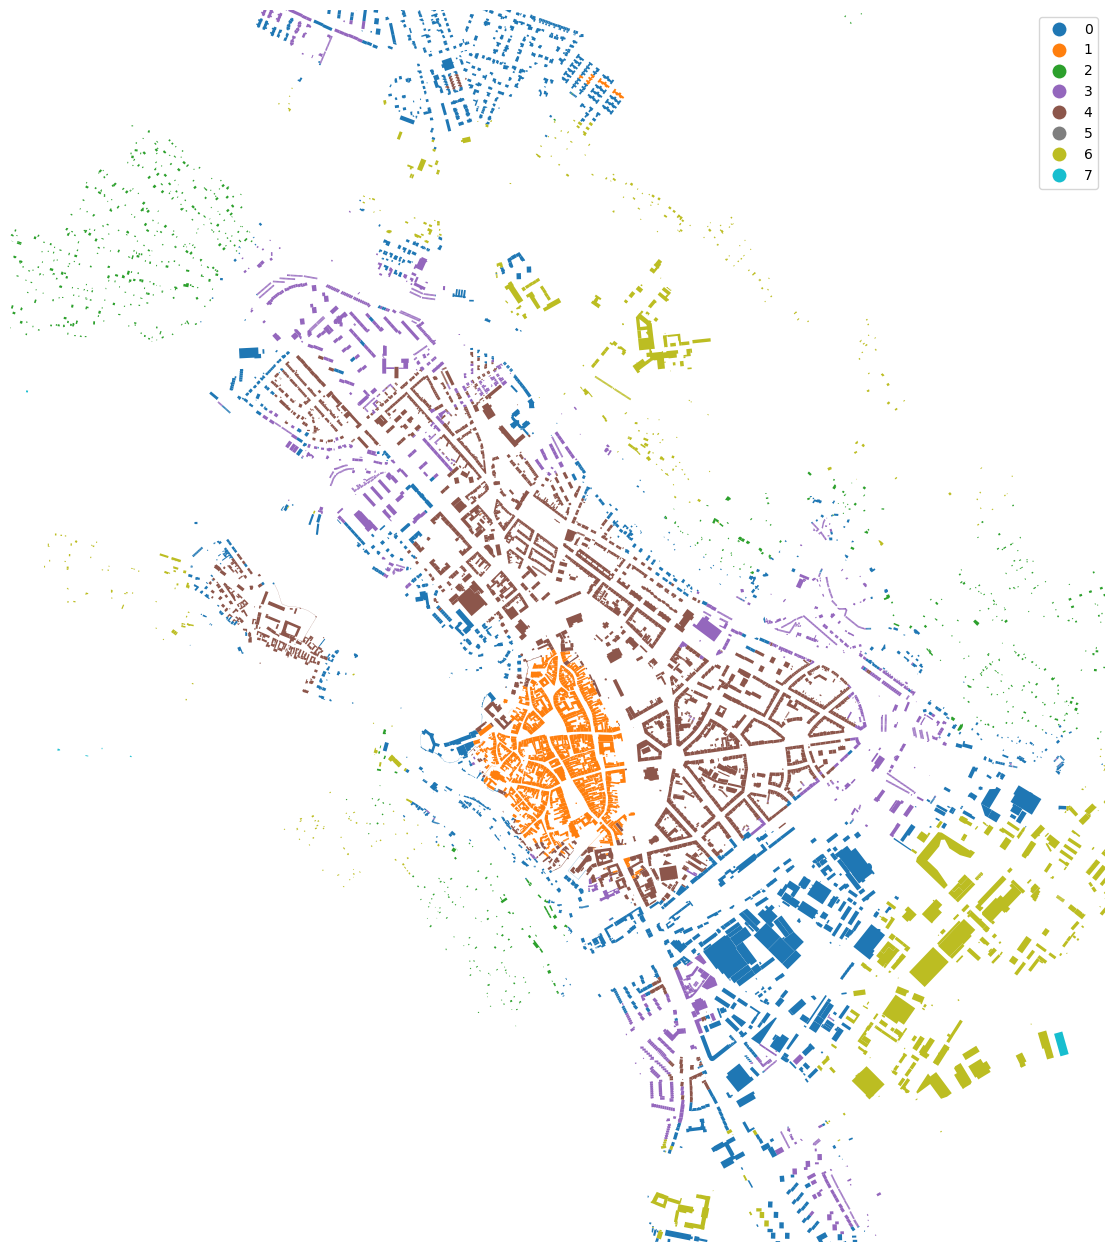

In [53]:
ax = urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True)
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()